# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 4: Predictor types and feature selection

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Nathaniel Burbank, Albert Wu<br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

<center>**Download this notebook from the CS109 repo or here:**</center>
<center>**http://bit.ly/109_S4**</center>

For this section, our goal is to continue discussing the complexities around different types of data features and thinking carefully about how different datatypes and collinearity issues can affect our models, whether our true goal is inference or prediction.

Specifically, we will: 
    
    1. Review different ways to plot multiple axes on a single figure in Matplotlib
    2. Discuss different variable types, and techniques of “one-hot-encoding” our factor variables 
    3. Build a variable selection function that performs an exhaustive feature search overall all possible combinations of predictors 


For this section we will be using the following packages:

In [1]:
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
# Note --  Requires sklearn version .18 or higher  
from sklearn import metrics, datasets
from collections import Counter
import statsmodels.formula.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

assert(sys.version_info.major==3),print(sys.version)
# Python 3 or higher is required

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Part (1): Review plotting on multiple axes within a single matplot lib figure

![](https://i.imgur.com/XTzSuoR.png)
source: http://matplotlib.org/faq/usage_faq.html

Some of the code in the plots below in this section was also adapted from [this](http://matplotlib.org/faq/usage_faq.html) matplotlib tutorial.

## Plot y1 and y2 on single figure 

In [2]:
x = np.arange(0, 10, 0.2)
y1 = np.sin(x)
y2 = np.exp(x)

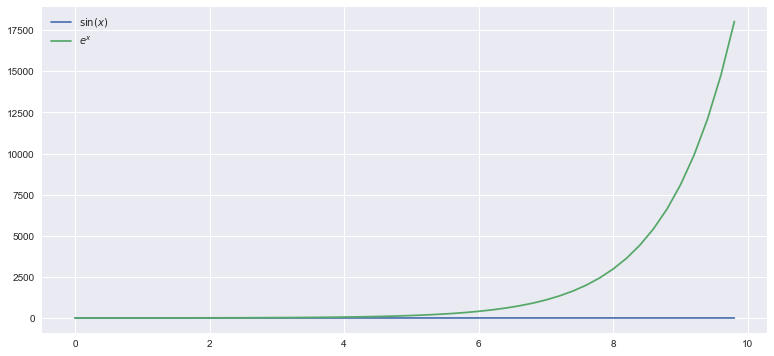

In [3]:
plt.plot(x,y1, label='$\sin(x)$')
plt.plot(x,y2, label='$e^x$')
plt.legend()
plt.show()

## Plot y1 and y2 on side by side axes

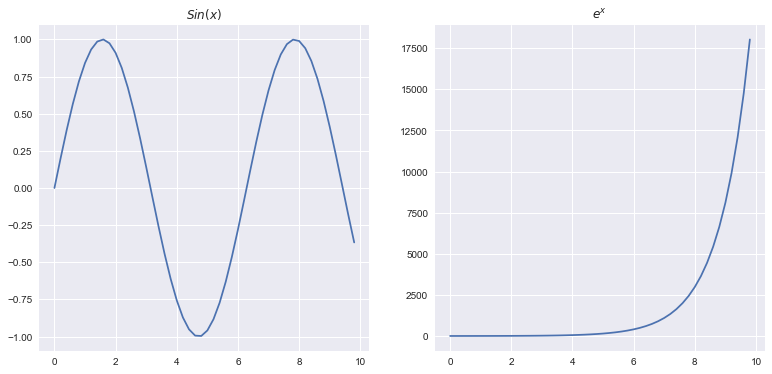

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(x, y1)
ax1.set_title("$Sin(x)$")

ax2 = fig.add_subplot(122)
ax2.plot(x, y2)
ax2.set_title("$e^x$")
plt.show()

## Plot y1 and y2 on side by side axes, sharing the same y-axis

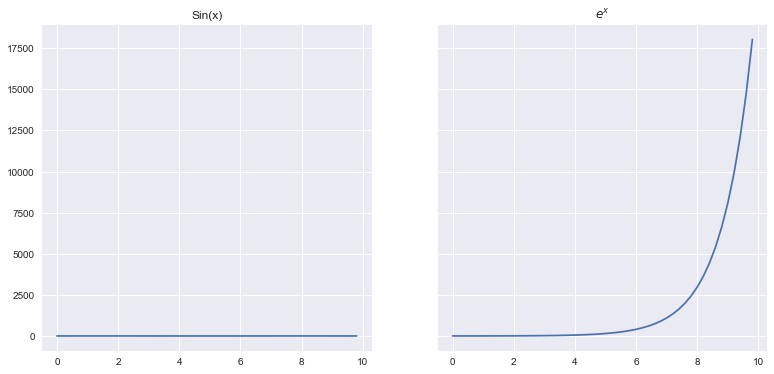

In [5]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y1)
ax1.set_title("Sin(x)")
ax2.plot(x, y2)
ax2.set_title("$e^x$")
plt.show()

## Plot y1 and y2 on separate (stacked) axes sharing the same x-axis 

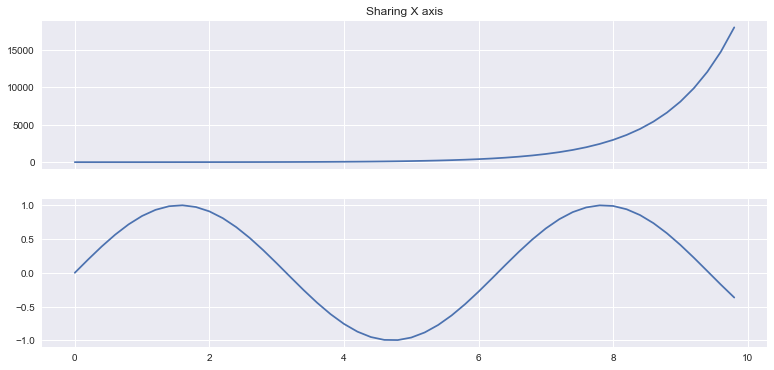

In [6]:
# Two subplots, the axes array is 1-d
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(x, y2)
ax1.set_title('Sharing X axis')
ax2.plot(x, y1)
plt.show()

## Four axes, returned as a 2-d array

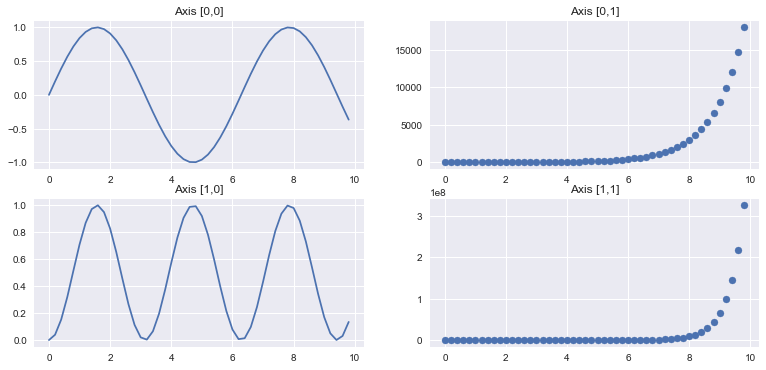

In [7]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y1)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y2)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y1 ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y2 ** 2)
axarr[1, 1].set_title('Axis [1,1]')
plt.show()

## Part (2): Logistic regression on Titanic data set 

In this part we’ll be using **[logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)** to predict the likelihood of different passengers surviving the titanic disaster. We have not discussed logistic regression much in class, but for now it’s enough to know that logistic regression is typically preferable to linear regression when the outcome variable we’re predicting falls into discreet categories (in this case survived or didn’t survived) rather than a continuous range. 

First let's load the dataset... 

In [8]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [9]:
# Subset to only cols we want
titanic = titanic[['sex', 'age', 'fare', 'class', 'survived']]

# Rename 'class' col to 'pclass' to avoid namespace issues
titanic.columns = ['sex', 'age', 'fare', 'pclass', 'survived']

#Drop any row with NA values in any col in dataframe
titanic = titanic.dropna()

titanic.head()

,sex,age,fare,pclass,survived
0,male,22.0,7.2500,Third,0
1,female,38.0,71.2833,First,1
2,female,26.0,7.9250,Third,1
3,female,35.0,53.1000,First,1
4,male,35.0,8.0500,Third,0


## Next, let’s start ploting out data with box plots

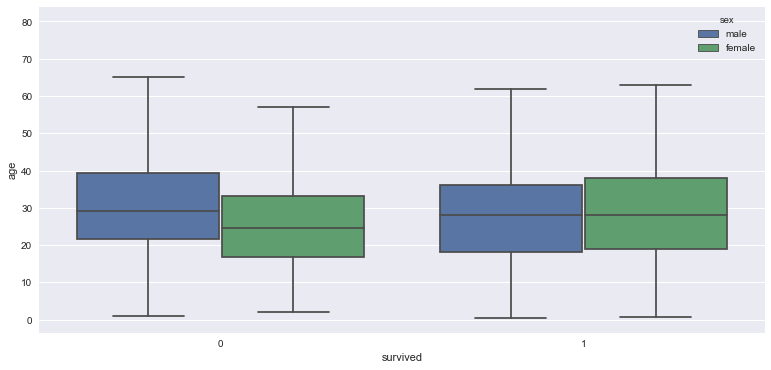

In [10]:
sns.boxplot(y="age",x="survived",hue="sex",data=titanic)
plt.show()

Age does not seem to be particularly informative. But there is something going on with gender?

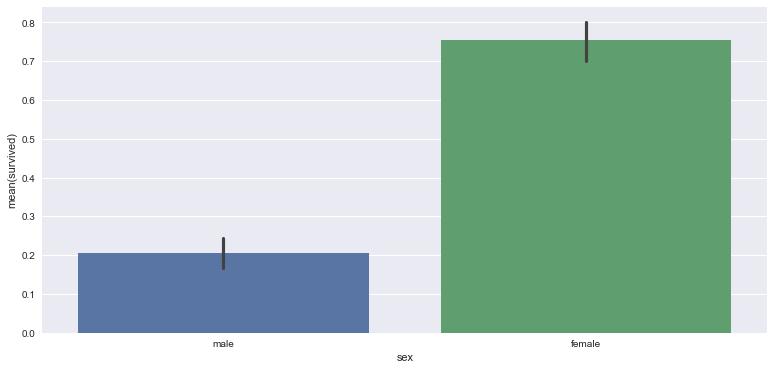

In [11]:
sns.barplot(x="sex", y="survived", data=titanic)
plt.show()

If we group by passenger class, we get an even more complete picture. 

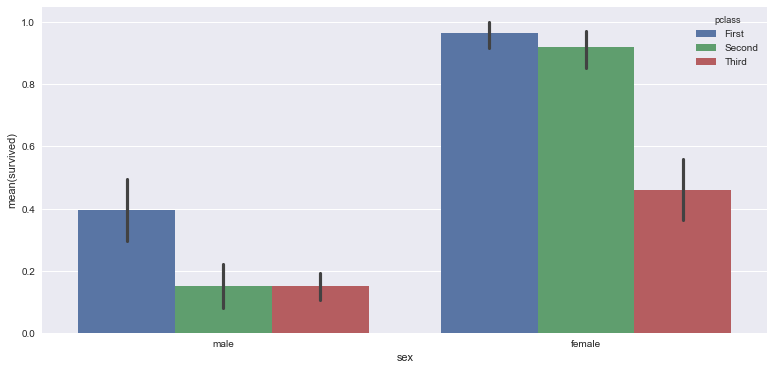

In [12]:
sns.barplot(x="sex", y="survived", hue='pclass', data=titanic)
plt.show()

## Define a series ‘is_female’, with 1s for women and 0s for men 

In [13]:
is_female = pd.get_dummies(titanic.sex)['female']
is_female.head()

#Note -- could also do this:
# is_female = titanic.sex == 'female' 
# although this leads to a slightly differnt var name below

0    0
1    1
2    1
3    1
4    0
Name: female, dtype: uint8

## "One hot encode" the passenger class column, and return a Dataframe with cols for 'First' and 'Second'

Why don’t we want to keep all three columns? 

In [14]:
pclass_coded = pd.get_dummies(titanic.pclass)[['First','Second']]
pclass_coded.head()

,First,Second
0,0,0
1,1,0
2,0,0
3,1,0
4,0,0


## Make a single dataframe with the encoded columns, plus 'age', 'fare' and 'survived' from the original dataframe. 

In [15]:
titanic_c = pd.concat([is_female,pclass_coded,titanic[['age','fare','survived']]],axis=1)
titanic_c.head()

,female,First,Second,age,fare,survived
0,0,0,0,22.0,7.2500,0
1,1,1,0,38.0,71.2833,1
2,1,0,0,26.0,7.9250,1
3,1,1,0,35.0,53.1000,1
4,0,0,0,35.0,8.0500,0


## Use train_test_split to divided our dataset in a 80% training set, and a 20% testing set. 

In [16]:
train, test =  train_test_split(titanic_c, test_size=.2, random_state=123)
train.shape,test.shape

((571, 6), (143, 6))

## Fit a logistic regression model and print the summary statistics. Do all the predictors seem significant?  

In [17]:
model = sm.logit(formula="survived ~ female + First + Second + age + fare", data=train)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.443663
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  571
Model:                          Logit   Df Residuals:                      565
Method:                           MLE   Df Model:                            5
Date:                Mon, 02 Oct 2017   Pseudo R-squ.:                  0.3445
Time:                        17:17:46   Log-Likelihood:                -253.33
converged:                       True   LL-Null:                       -386.45
                                        LLR p-value:                 1.806e-55
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3845      0.288     -4.808      0.000      -1.949      -0.820
female         2.6533      0.238     11.138      0.000       2.186       3.120
First          2.4977      0.364      6.860      0.000       1.784       3.211
Second         1.1223      0.280      4.004      0.000       0.573       1.672
age           -0.0352      0.009     -3.988      0.000      -0.053      -0.018
fare           0.0013      0.002      0.528      0.597      -0.004       0.006
==============================================================================
"""

Hmm…it seems like the fare predictor is not really helpful in our model. What’s going on?

(0, 250)

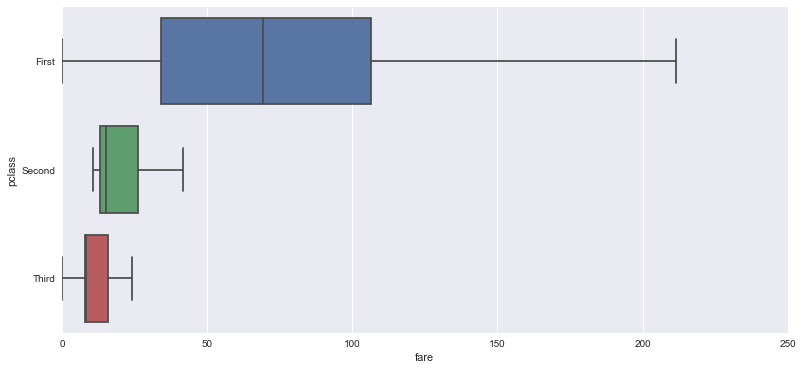

In [18]:
ax = sns.boxplot(titanic.fare,titanic.pclass)
ax.set_xlim([0,250])

Ah, fare clearly highly correlated with passenger class. Let’s drop it for now.

In [19]:
model = sm.logit(formula="survived ~ female + First + Second + age", data=train)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.443915
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  571
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            4
Date:                Mon, 02 Oct 2017   Pseudo R-squ.:                  0.3441
Time:                        17:17:47   Log-Likelihood:                -253.48
converged:                       True   LL-Null:                       -386.45
                                        LLR p-value:                 2.391e-56
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3532      0.282     -4.801      0.000      -1.906      -0.801
female         2.6625      0.238     11.207      0.000       2.197       3.128
First          2.5966      0.314      8.276      0.000       1.982       3.212
Second         1.1384      0.279      4.080      0.000       0.591       1.685
age           -0.0360      0.009     -4.124      0.000      -0.053      -0.019
==============================================================================
"""

## Let’s test our model on the set-aside test set. 

In [20]:
predicted = np.round(model.predict(test[['female','First','Second','age']]))
expected = test['survived']
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.80      0.79      0.80        87
          1       0.68      0.70      0.69        56

avg / total       0.76      0.76      0.76       143



In [21]:
pd.crosstab(expected,predicted,margins=True)

col_0,0.0,1.0,All
survived,,,
0,69,18,87
1,17,39,56
All,86,57,143


The row totals (87 died, 56 survived) above represent the true number of individuals in our test set that survived or perished on the titanic. The columns represent what our model predicted. Per the precision stats above, our model is getting about 3/4  of the test set correctly categorized, but still has a lot of false negatives and false positives.

## Part (3) Model Selection via exhaustive search selection

The data set for this problem contains 10 simulated predictors and a response variable. 

Import the data...

In [22]:
data = pd.read_csv('https://raw.githubusercontent.com/nathanielburbank/CS109/master/data/sec4_dataset.txt')
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.959357,0.959357,0.959357,0.343727,0.524083,0.537768,0.435598,0.831999,0.153247,0.005016,0.289394
1,0.616969,0.616969,0.616969,0.287376,0.513844,0.497775,0.452732,0.914609,0.367390,0.444473,-0.277574
2,0.995941,0.995941,0.995941,0.107294,0.097106,0.146751,0.136414,0.635926,0.535209,0.899457,-0.513097
3,0.821732,0.821732,0.821732,0.202558,0.329504,0.359471,0.281453,0.106263,0.479327,0.256271,-0.182353
4,0.302423,0.302423,0.302423,0.184564,0.270263,0.293385,0.263866,0.378630,0.740241,0.468589,-0.625117


By visually inspecting the data set, do we find that some of the predictors are correlated amongst themselves?

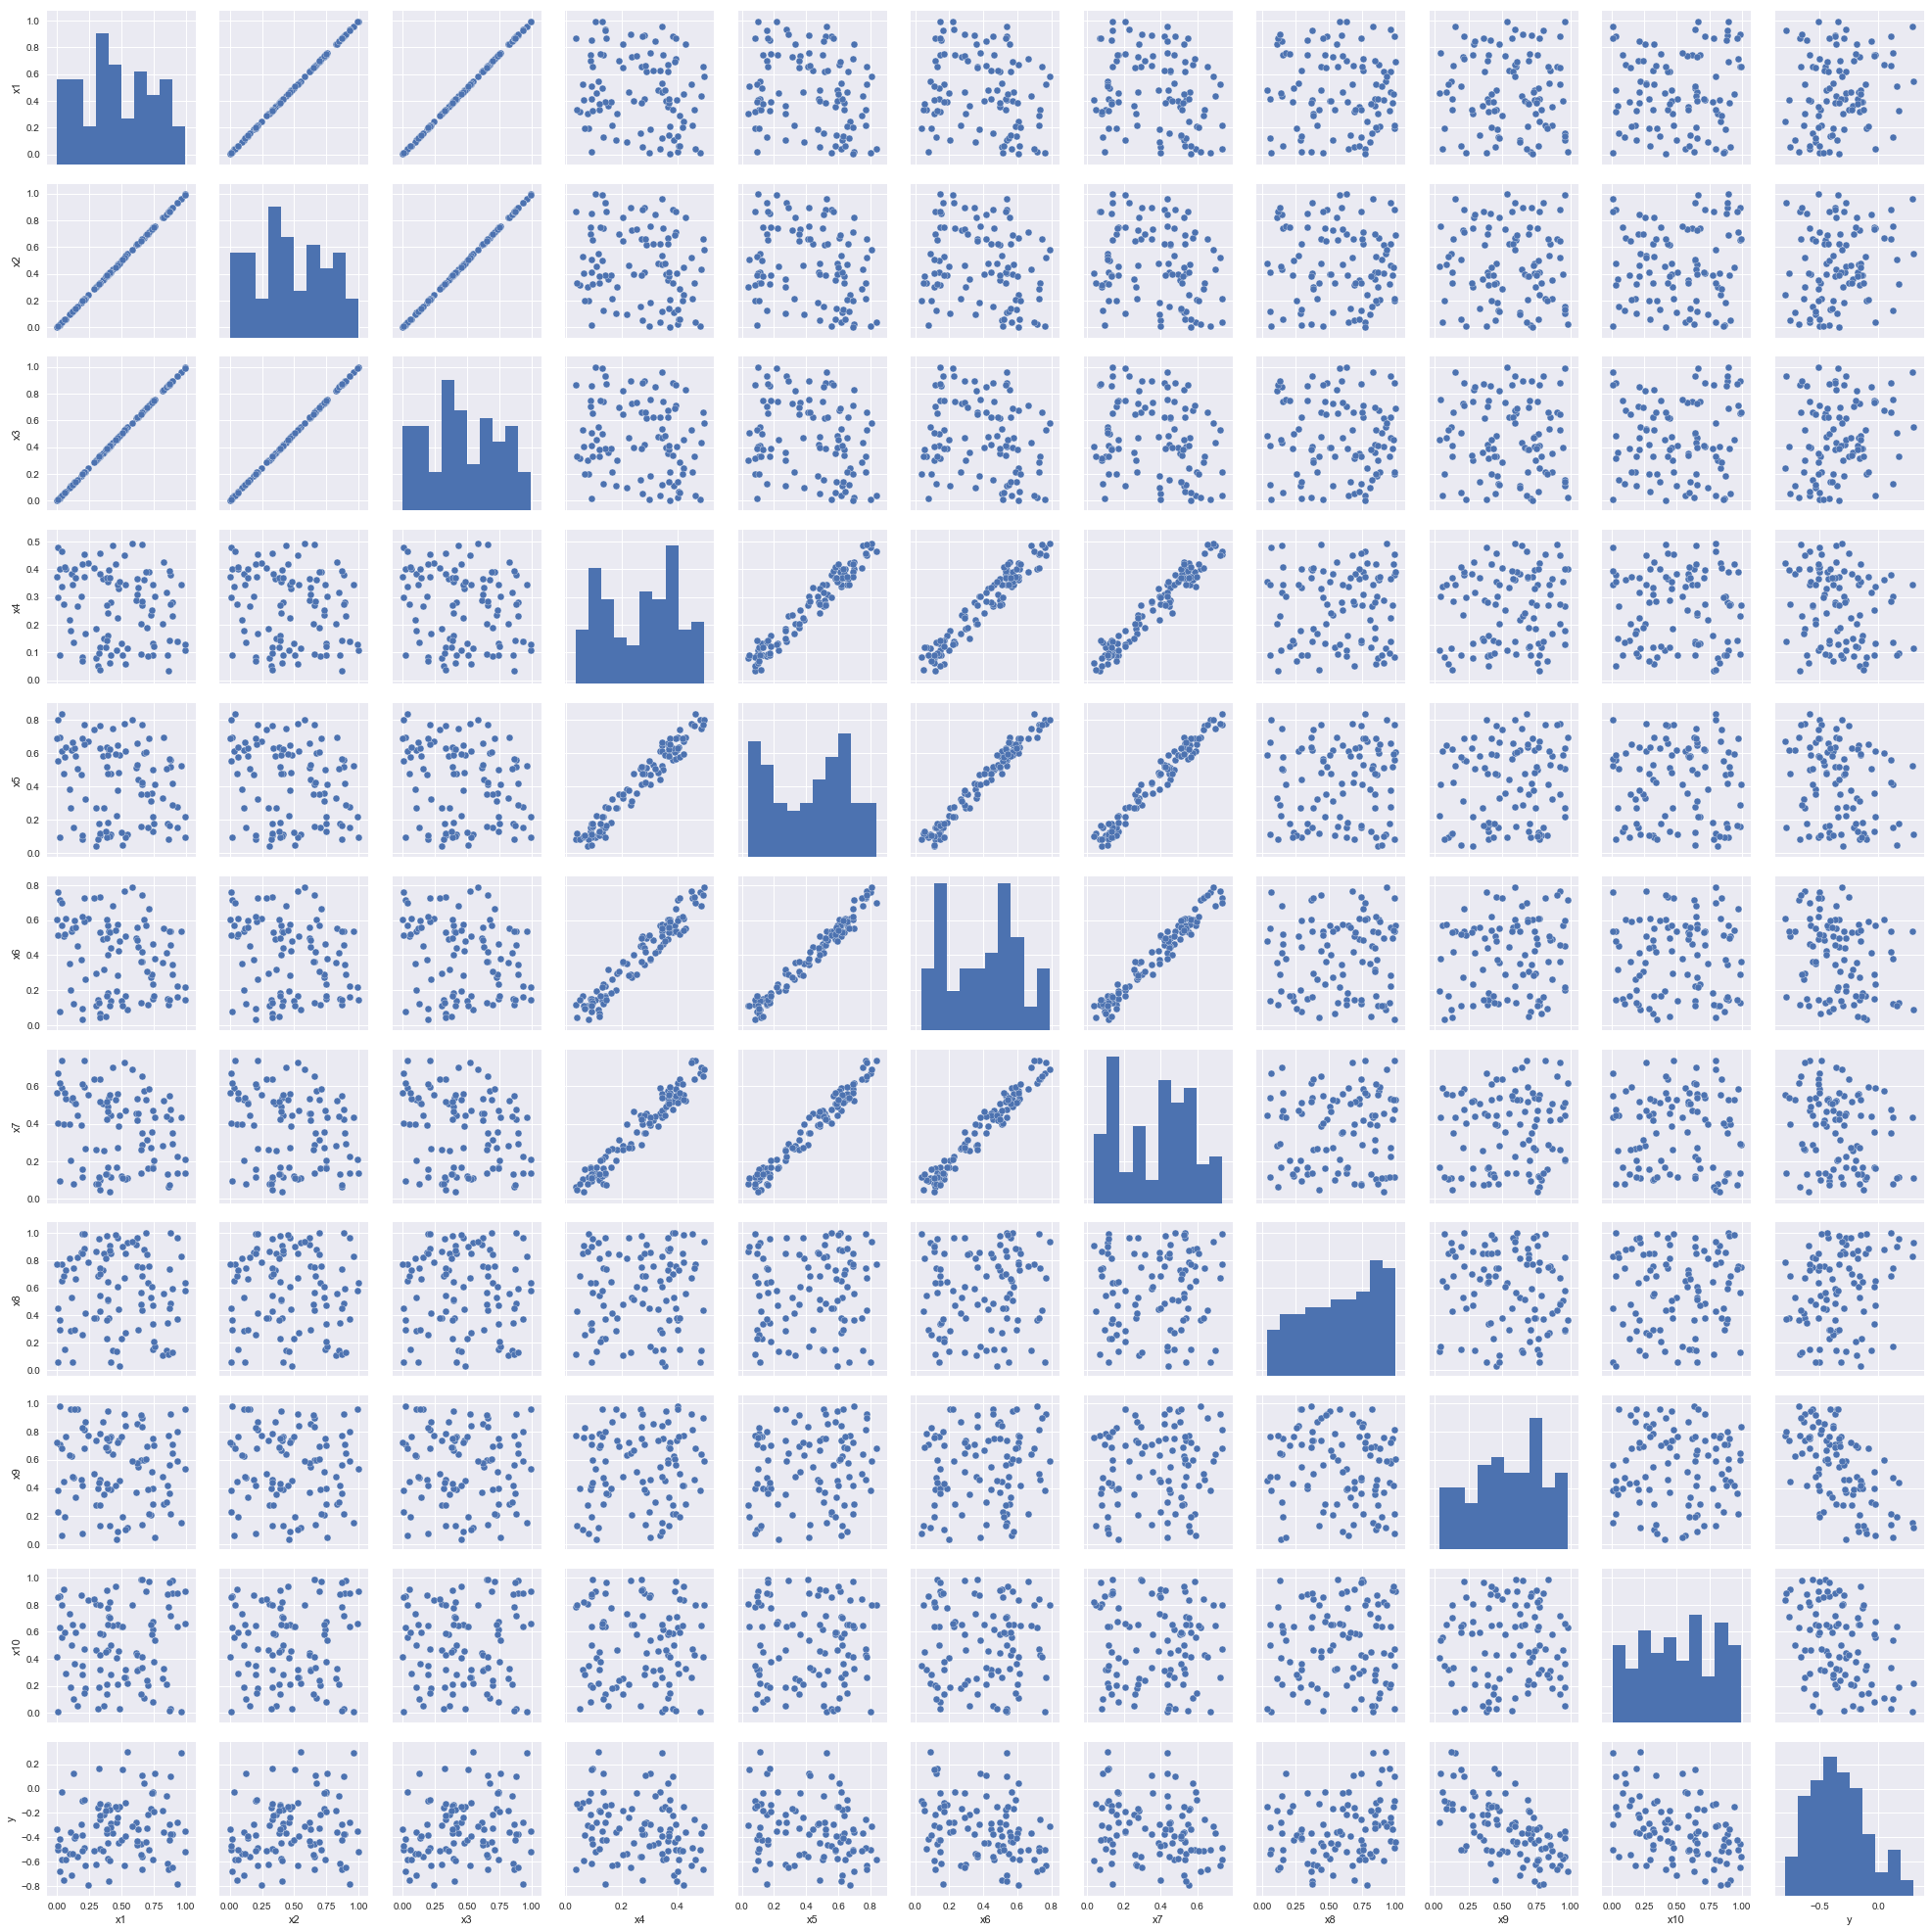

In [23]:
sns.pairplot(data)

Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?

In [24]:
data.corr()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
x1,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x2,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x3,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x4,-0.189945,-0.189945,-0.189945,1.000000,0.974279,0.964344,0.969540,0.058516,0.108294,-0.010416,-0.225856
x5,-0.232439,-0.232439,-0.232439,0.974279,1.000000,0.982785,0.982227,0.080342,0.126004,-0.012399,-0.257433
x6,-0.215623,-0.215623,-0.215623,0.964344,0.982785,1.000000,0.976308,0.079547,0.123368,-0.021029,-0.261228
x7,-0.228322,-0.228322,-0.228322,0.969540,0.982227,0.976308,1.000000,0.074004,0.112241,-0.022023,-0.235921
x8,-0.047643,-0.047643,-0.047643,0.058516,0.080342,0.079547,0.074004,1.000000,-0.133182,0.052151,0.238538
x9,-0.061022,-0.061022,-0.061022,0.108294,0.126004,0.123368,0.112241,-0.133182,1.000000,0.006923,-0.607845
x10,0.050977,0.050977,0.050977,-0.010416,-0.012399,-0.021029,-0.022023,0.052151,0.006923,1.000000,-0.406231


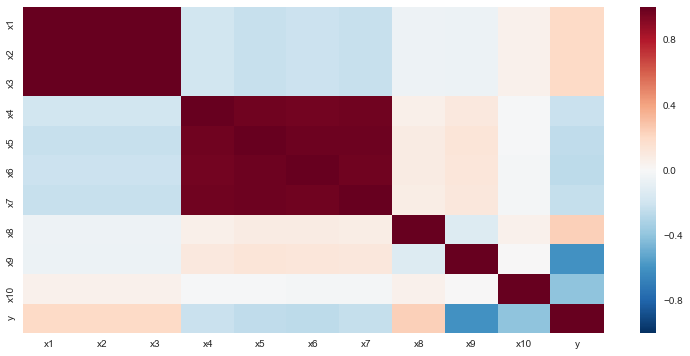

In [25]:
sns.heatmap(data.corr())

If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? 

## Review Model Selection Criterion


### Bayesian Information Criterion (BIC)

– Generally BIC = -2 x Log-likehood + 2 x log(K)

– For least-squares regression specifically: 

$$BIC = n \log \Big(\frac{RSS}{n}\Big) + \log(n)*K$$

Where:
RSS = Residual Sum of Squares

n = the number of obervations 

K = the number of features in our model
    

### Part (b): Selecting minimal subset of predictors

- Apply the Exhaustive search variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy. Use the Bayesian Information Criterion (BIC) to choose the subset size.

In [26]:
import itertools

def exhaustive_search_selection(x, y):
    """Exhaustively search predictor combinations. .

    Parameters:
    -----------
    x : DataFrame of predictors/features
    y : response varible 
    
    
    Returns:
    -----------
    
    Dataframe of model comparisons and OLS Model with 
    lowest BIC for subset with highest R^2
    
    """
    
    # total no. of predictors
    d = x.shape[1]
    predictors = x.columns
    overall_min_bic = 10000 # A big number 
    output = dict()
    
    # Outer loop: iterate over sizes 1 .... d
    for k in range(1,d):
        
        max_r_squared = -10000 # A small number
        
        # Enumerate subsets of size ‘k’
        subsets_k = itertools.combinations(predictors, k)
        
        # Inner loop: iterate through subsets_k
        for subset in subsets_k:
            # Fit regression model using ‘subset’ and calculate R^2 
            # Keep track of subset with highest R^2
            
            features = list(subset)
            x_subset = x[features]
            
            model = OLS(y, x_subset)
            results = model.fit()
            r_squared = results.rsquared
            
            # Check if we get a higher R^2 value than than current max R^2, 
            # if so, update our best subset 
            if(r_squared > max_r_squared):
                max_r_squared = r_squared
                best_subset = features
                best_model = model
                best_formula = "y ~ {}".format(' + '.join(features))
        
        results = best_model.fit()
        bic = results.bic
        if bic < overall_min_bic:
            overall_min_bic = bic 
            best_overall_subset = best_subset
            best_overall_rsquared = results.rsquared
            best_overall_formula = best_formula
            best_overall_model = best_model
        
        #print("For k={0} the best model is {1} with bic={2:.2f} and R^2={3:.4f}".format(k,best_formula,bic,results.rsquared))
        output[k] = {'best_model':best_formula, 'bic':bic,'r_squared':results.rsquared}
        
    print("The best overall model is {0} with bic={1:.2f} and R^2={2:.3f}".format(best_overall_formula,overall_min_bic, best_overall_rsquared))
    
    return pd.DataFrame(output).T,best_overall_model     

In [27]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1:]
stats,model = exhaustive_search_selection(x,y)
stats

The best overall model is y ~ x1 + x6 + x8 + x9 + x10 with bic=-76.65 and R^2=0.874


,best_model,bic,r_squared
1,y ~ x9,-40.9645,0.784064
2,y ~ x9 + x10,-57.9035,0.825915
3,y ~ x8 + x9 + x10,-68.4179,0.850343
4,y ~ x1 + x8 + x9 + x10,-72.6382,0.862985
5,y ~ x1 + x6 + x8 + x9 + x10,-76.6452,0.874291
6,y ~ x1 + x4 + x6 + x8 + x9 + x10,-74.8907,0.877824
7,y ~ x1 + x4 + x6 + x7 + x8 + x9 + x10,-70.7052,0.878336
8,y ~ x1 + x4 + x5 + x6 + x7 + x8 + x9 + x10,-66.3744,0.878669
9,y ~ x1 + x2 + x4 + x5 + x6 + x7 + x8 + x9 + x10,-66.3744,0.878669


In [28]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     132.1
Date:                Mon, 02 Oct 2017   Prob (F-statistic):           3.49e-41
Time:                        17:18:11   Log-Likelihood:                 49.836
No. Observations:                 100   AIC:                            -89.67
Df Residuals:                      95   BIC:                            -76.65
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1494      0.049      3.074      0.003       0.053       0.246
x6            -0.1978      0.068     -2.923      0.004      -0.332      -0.063
x8             0.1957      0.048      4.114      0.000       0.101       0.290
x9            -0.4918      0.051     -9.553      0.000      -0.594      -0.390
x10           -0.3485      0.050     -7.039      0.000      -0.447      -0.250
==============================================================================
Omnibus:                       29.371   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.768
Skew:                           0.061   Prob(JB):                       0.0559
Kurtosis:                       1.830   Cond. No.                         5.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?